<a href="https://colab.research.google.com/github/hhduke2014/marked-beetle-analysis/blob/main/1200efficientnet_B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]

['PaperedControl20d.tif',
 'PaperedControl20d_light.tif',
 'PaperedControl21v.tif',
 'PaperedControl21v_light.tif']

In [5]:
train_images=[]
for filename in filenames:
    if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 801


In [6]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [7]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

801

In [8]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl20d.tif,marked
1,PaperedControl20d_light.tif,marked
2,PaperedControl21v.tif,marked
3,PaperedControl21v_light.tif,marked
4,PaperedControl21d.tif,marked
...,...,...
796,PaperedControl18d.tif,marked
797,PaperedControl19v.tif,marked
798,PaperedControl19d.tif,marked
799,PaperedControl20v.tif,marked


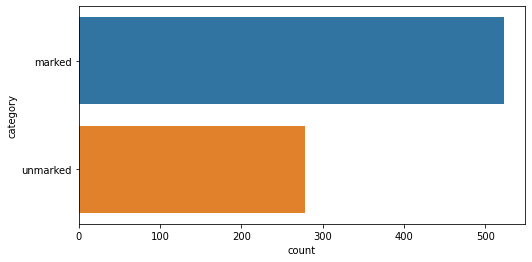

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [10]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [11]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [12]:
tmp_df = df.sample(9)
tmp_df

,filename,category
323,PaperedTransparent84v.tif,marked
762,NoPaperedGreen3v.tif,unmarked
448,NoPaperedGreen47v.tif,unmarked
78,PaperedControl51d.tif,marked
621,NoPaperedMixed48d.tif,unmarked
285,PaperedTransparent66d.tif,marked
277,PaperedTransparent62d.tif,marked
254,PaperedTransparent51d_light.tif,marked
35,PaperedControl34v.tif,marked


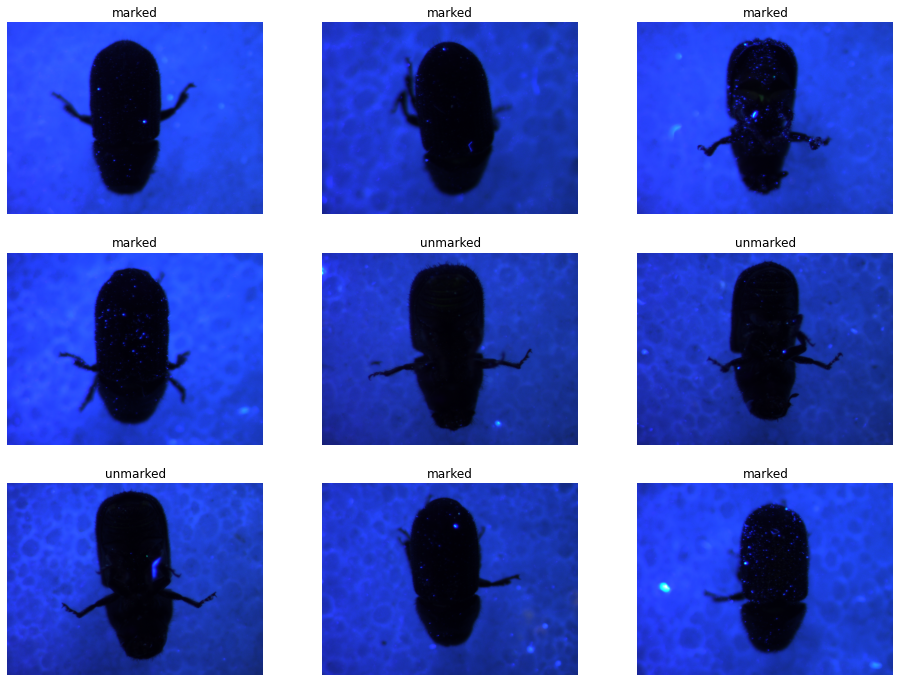

In [13]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [13]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

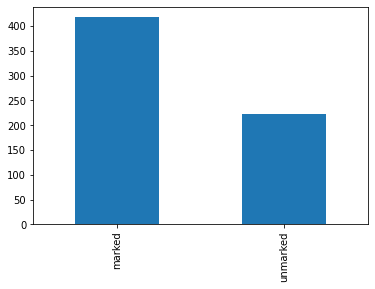

In [14]:
train_df['category'].value_counts().plot.bar()

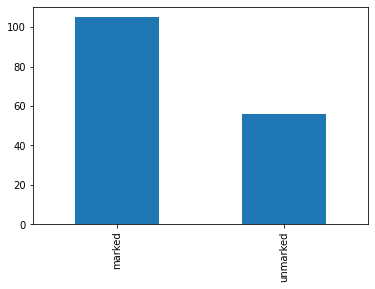

In [15]:
validate_df['category'].value_counts().plot.bar()

In [16]:
IMG_SIZE = 1200
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 15

In [17]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    #brightness_range = [0.3,0.9],
                    #channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [18]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [19]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 640 validated image filenames belonging to 2 classes.


In [20]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 161 validated image filenames belonging to 2 classes.


In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers

def create_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    #x = layers.Flatten()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

In [22]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [23]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("best_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [24]:
results = Model_fit()

Epoch 1/50
42/42 [==============================] - 1004s 23s/step - loss: 0.9918 - accuracy: 0.7888 - val_loss: 0.4459 - val_accuracy: 0.7933


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
42/42 [==============================] - 573s 14s/step - loss: 0.6342 - accuracy: 0.8592 - val_loss: 0.4452 - val_accuracy: 0.7667
Epoch 3/50
42/42 [==============================] - 571s 14s/step - loss: 0.4941 - accuracy: 0.8736 - val_loss: 0.3468 - val_accuracy: 0.8667
Epoch 4/50
42/42 [==============================] - 565s 13s/step - loss: 0.4498 - accuracy: 0.8864 - val_loss: 0.3920 - val_accuracy: 0.7733
Epoch 5/50
42/42 [==============================] - 564s 13s/step - loss: 0.4010 - accuracy: 0.8848 - val_loss: 0.3147 - val_accuracy: 0.8600
Epoch 6/50
42/42 [==============================] - 567s 13s/step - loss: 0.5431 - accuracy: 0.8752 - val_loss: 0.3639 - val_accuracy: 0.8000
Epoch 7/50
42/42 [==============================] - 573s 14s/step - loss: 0.3070 - accuracy: 0.9056 - val_loss: 0.4705 - val_accuracy: 0.7867

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 8/50
42/42 [==============================] - 574s 14s/step 

In [25]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.9359999895095825
Val_Cat-Acc:  0.9133333563804626


In [26]:
print('Train_Cat-Loss: ', min(results.history['loss']))
print('Val_Cat-Loss: ', min(results.history['val_loss']))

Train_Cat-Loss:  0.14937716722488403
Val_Cat-Loss:  0.20769669115543365


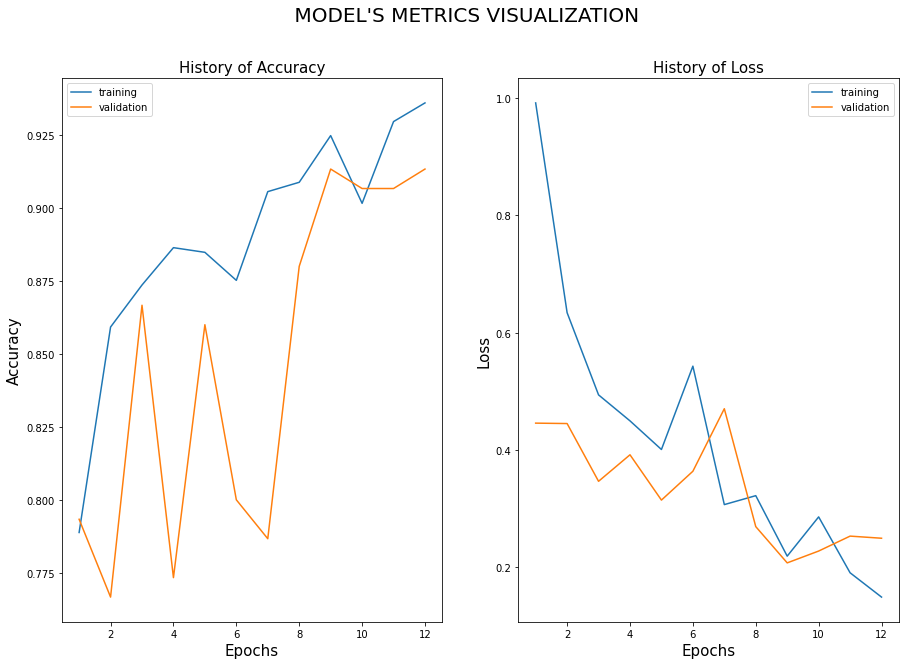

In [27]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [107]:
import keras

final_model = keras.models.load_model('1best_model.h5')

In [160]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
464,NoPaperedGreen55d.tif,unmarked
324,PaperedTransparent84d.tif,marked
134,PaperedControl76v_light.tif,marked
411,NoPaperedGreen19d.tif,unmarked
190,PaperedTransparent22v.tif,marked
136,PaperedControl76d_light.tif,marked
659,PaperedMixed17d.tif,marked
0,PaperedControl20d.tif,marked
773,NoPaperedGreen9v.tif,unmarked
743,PaperedControl4v.tif,marked


In [154]:
nb_samples = tmp_df1.shape[0]

In [155]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)
test_generator = test_gen.flow_from_dataframe(
    tmp_df1, 
    "/content/drive/MyDrive/MarkedBeetleImageAnalysis/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10 validated image filenames.


In [161]:
predict = final_model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [162]:
tmp_df1['prediction'] = np.argmax(predict, axis=-1)
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
464,NoPaperedGreen55d.tif,unmarked,marked
324,PaperedTransparent84d.tif,marked,marked
134,PaperedControl76v_light.tif,marked,marked
411,NoPaperedGreen19d.tif,unmarked,marked
190,PaperedTransparent22v.tif,marked,marked
136,PaperedControl76d_light.tif,marked,marked
659,PaperedMixed17d.tif,marked,marked
0,PaperedControl20d.tif,marked,marked
773,NoPaperedGreen9v.tif,unmarked,marked
743,PaperedControl4v.tif,marked,marked


In [149]:
final_modell = keras.models.load_model('best_model.h5')

In [163]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize((600,600))
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_modell.predict(image)))
tmp_df1["prediction1"]=preds

In [164]:
tmp_df1["prediction1"] = tmp_df1["prediction1"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction,prediction1
464,NoPaperedGreen55d.tif,unmarked,marked,marked
324,PaperedTransparent84d.tif,marked,marked,marked
134,PaperedControl76v_light.tif,marked,marked,marked
411,NoPaperedGreen19d.tif,unmarked,marked,unmarked
190,PaperedTransparent22v.tif,marked,marked,marked
136,PaperedControl76d_light.tif,marked,marked,marked
659,PaperedMixed17d.tif,marked,marked,marked
0,PaperedControl20d.tif,marked,marked,marked
773,NoPaperedGreen9v.tif,unmarked,marked,marked
743,PaperedControl4v.tif,marked,marked,marked
